**RACE OUTCOME ANALYSIS**
*Predict podium positions for Italian Grand Prix 2025 (Monza - Sept 7, 2025)*

Imports and set up

In [1]:
!pip install fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

#FastF1 and ML libraries
import fastf1
import fastf1.plotting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
from datetime import datetime
import requests
import json
import os

#FastF1 cache
os.makedirs('f1_cache', exist_ok=True)
fastf1.Cache.enable_cache('f1_cache')

plt.style.use('seaborn-v0_8')
fastf1.plotting.setup_mpl()

Data collection

In [3]:
def create_mock_data():
    race_data = {
        'year': [2020, 2020, 2021, 2021, 2022, 2022, 2023, 2023, 2024, 2024, 2020, 2021, 2022, 2023, 2024],
        'round': [8, 8, 14, 14, 16, 16, 15, 15, 16, 16, 8, 14, 16, 15, 16],
        'circuit': ['Monza'] * 15,
        'date': ['2020-09-06', '2020-09-06', '2021-09-12', '2021-09-12', '2022-09-11', '2022-09-11',
                 '2023-09-03', '2023-09-03', '2024-09-01', '2024-09-01', '2020-09-06', '2021-09-12', '2022-09-11',
                 '2023-09-03', '2024-09-01'],
        'driver': ['Gasly', 'Sainz', 'Ricciardo', 'Norris', 'Verstappen', 'Leclerc', 'Verstappen', 'Perez',
                   'Leclerc', 'Piastri', 'Hamilton', 'Bottas', 'Russell', 'Alonso', 'Ocon'],
        'driver_code': ['GAS', 'SAI', 'RIC', 'NOR', 'VER', 'LEC', 'VER', 'PER', 'LEC', 'PIA', 'HAM', 'BOT', 'RUS',
                        'ALO', 'OCO'],
        'constructor': ['AlphaTauri', 'McLaren', 'McLaren', 'McLaren', 'Red Bull', 'Ferrari', 'Red Bull', 'Red Bull',
                        'Ferrari', 'McLaren', 'Mercedes', 'Mercedes', 'Mercedes', 'Aston Martin', 'Alpine'],
        'grid': [10, 3, 2, 3, 7, 1, 1, 2, 1, 2, 5, 1, 4, 8, 11],
        'position': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 7, 3, 5, 9, 10],
        'points': [25, 18, 26, 18, 25, 18, 25, 18, 25, 18, 6, 15, 10, 2, 1],
        'status': ['Finished'] * 15,
        'podium': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
    }
    df_races = pd.DataFrame(race_data)

    qualifying_data = {
        'year': [2020, 2020, 2021, 2021, 2022, 2022, 2023, 2023, 2024, 2024, 2020, 2021, 2022, 2023, 2024],
        'round': [8, 8, 14, 14, 16, 16, 15, 15, 16, 16, 8, 14, 16, 15, 16],
        'circuit': ['Monza'] * 15,
        'driver': ['Gasly', 'Sainz', 'Ricciardo', 'Norris', 'Verstappen', 'Leclerc', 'Verstappen', 'Perez',
                   'Leclerc', 'Piastri', 'Hamilton', 'Bottas', 'Russell', 'Alonso', 'Ocon'],
        'constructor': ['AlphaTauri', 'McLaren', 'McLaren', 'McLaren', 'Red Bull', 'Ferrari', 'Red Bull', 'Red Bull',
                        'Ferrari', 'McLaren', 'Mercedes', 'Mercedes', 'Mercedes', 'Aston Martin', 'Alpine'],
        'qual_position': [10, 3, 2, 3, 7, 1, 1, 2, 1, 2, 5, 1, 4, 8, 11],
        'q1': ['1:20.1', '1:20.2', '1:20.3', '1:20.4', '1:20.5', '1:20.6', '1:20.7', '1:20.8', '1:20.9', '1:21.0',
               '1:19.5', '1:19.8', '1:20.3', '1:21.1', '1:21.5'],
        'q2': ['1:19.1', '1:19.2', '1:19.3', '1:19.4', '1:19.5', '1:19.6', '1:19.7', '1:19.8', '1:19.9', '1:20.0',
               '1:18.9', '1:19.2', '1:19.7', '1:20.5', '1:20.9'],
        'q3': ['1:18.1', '1:18.2', '1:18.3', '1:18.4', '1:18.5', '1:18.6', '1:18.7', '1:18.8', '1:18.9', '1:19.0',
               '1:18.3', '1:18.5', '1:19.1', '1:19.8', '1:20.2']
    }
    df_qualifying = pd.DataFrame(qualifying_data)

    return df_races, df_qualifying

df_races, df_qualifying = create_mock_data()

Data preprocessing

In [4]:
def preprocess_data(df_races, df_qualifying):
    print("Preprocessing data and engineering features")
    df_merged = df_races.merge(
        df_qualifying[['year', 'round', 'driver', 'qual_position']],
        on=['year', 'round', 'driver'],
        how='left'
    )
    df_merged['qual_position'] = df_merged['qual_position'].fillna(20)
    df_merged['grid_qual_diff'] = df_merged['grid'] - df_merged['qual_position']

    constructor_stats = df_merged.groupby(['year', 'constructor']).agg({
        'points': 'mean',
        'podium': 'mean',
        'position': 'mean'
    }).reset_index()
    constructor_stats.columns = ['year', 'constructor', 'constructor_avg_points',
                                 'constructor_podium_rate', 'constructor_avg_position']
    df_merged = df_merged.merge(constructor_stats, on=['year', 'constructor'], how='left')

    df_merged = df_merged.sort_values(['driver', 'year', 'round'])
    df_merged['driver_points_rolling'] = df_merged.groupby('driver')['points'].rolling(5, min_periods=1).mean().reset_index(drop=True)
    df_merged['driver_podium_rolling'] = df_merged.groupby('driver')['podium'].rolling(5, min_periods=1).mean().reset_index(drop=True)

    circuit_difficulty = df_merged.groupby('circuit').agg({
        'podium': 'mean',
        'points': 'mean'
    }).reset_index()
    circuit_difficulty.columns = ['circuit', 'circuit_podium_rate', 'circuit_avg_points']
    df_merged = df_merged.merge(circuit_difficulty, on='circuit', how='left')

    df_merged['front_row'] = (df_merged['grid'] <= 2).astype(int)
    df_merged['top_10'] = (df_merged['grid'] <= 10).astype(int)

    df_clean = df_merged[df_merged['position'].notna()].copy()

    feature_columns = [
        'grid', 'qual_position', 'grid_qual_diff',
        'constructor_avg_points', 'constructor_podium_rate', 'constructor_avg_position',
        'driver_points_rolling', 'driver_podium_rolling',
        'circuit_podium_rate', 'circuit_avg_points',
        'front_row', 'top_10'
    ]
    df_clean = df_clean.dropna(subset=feature_columns + ['podium'])

    print(f"Preprocessed data: {len(df_clean)} records ready for modeling")
    return df_clean, feature_columns

df_processed, features = preprocess_data(df_races, df_qualifying)

Preprocessing data and engineering features
Preprocessed data: 15 records ready for modeling


EDA

Performing Exploratory Data Analysis...


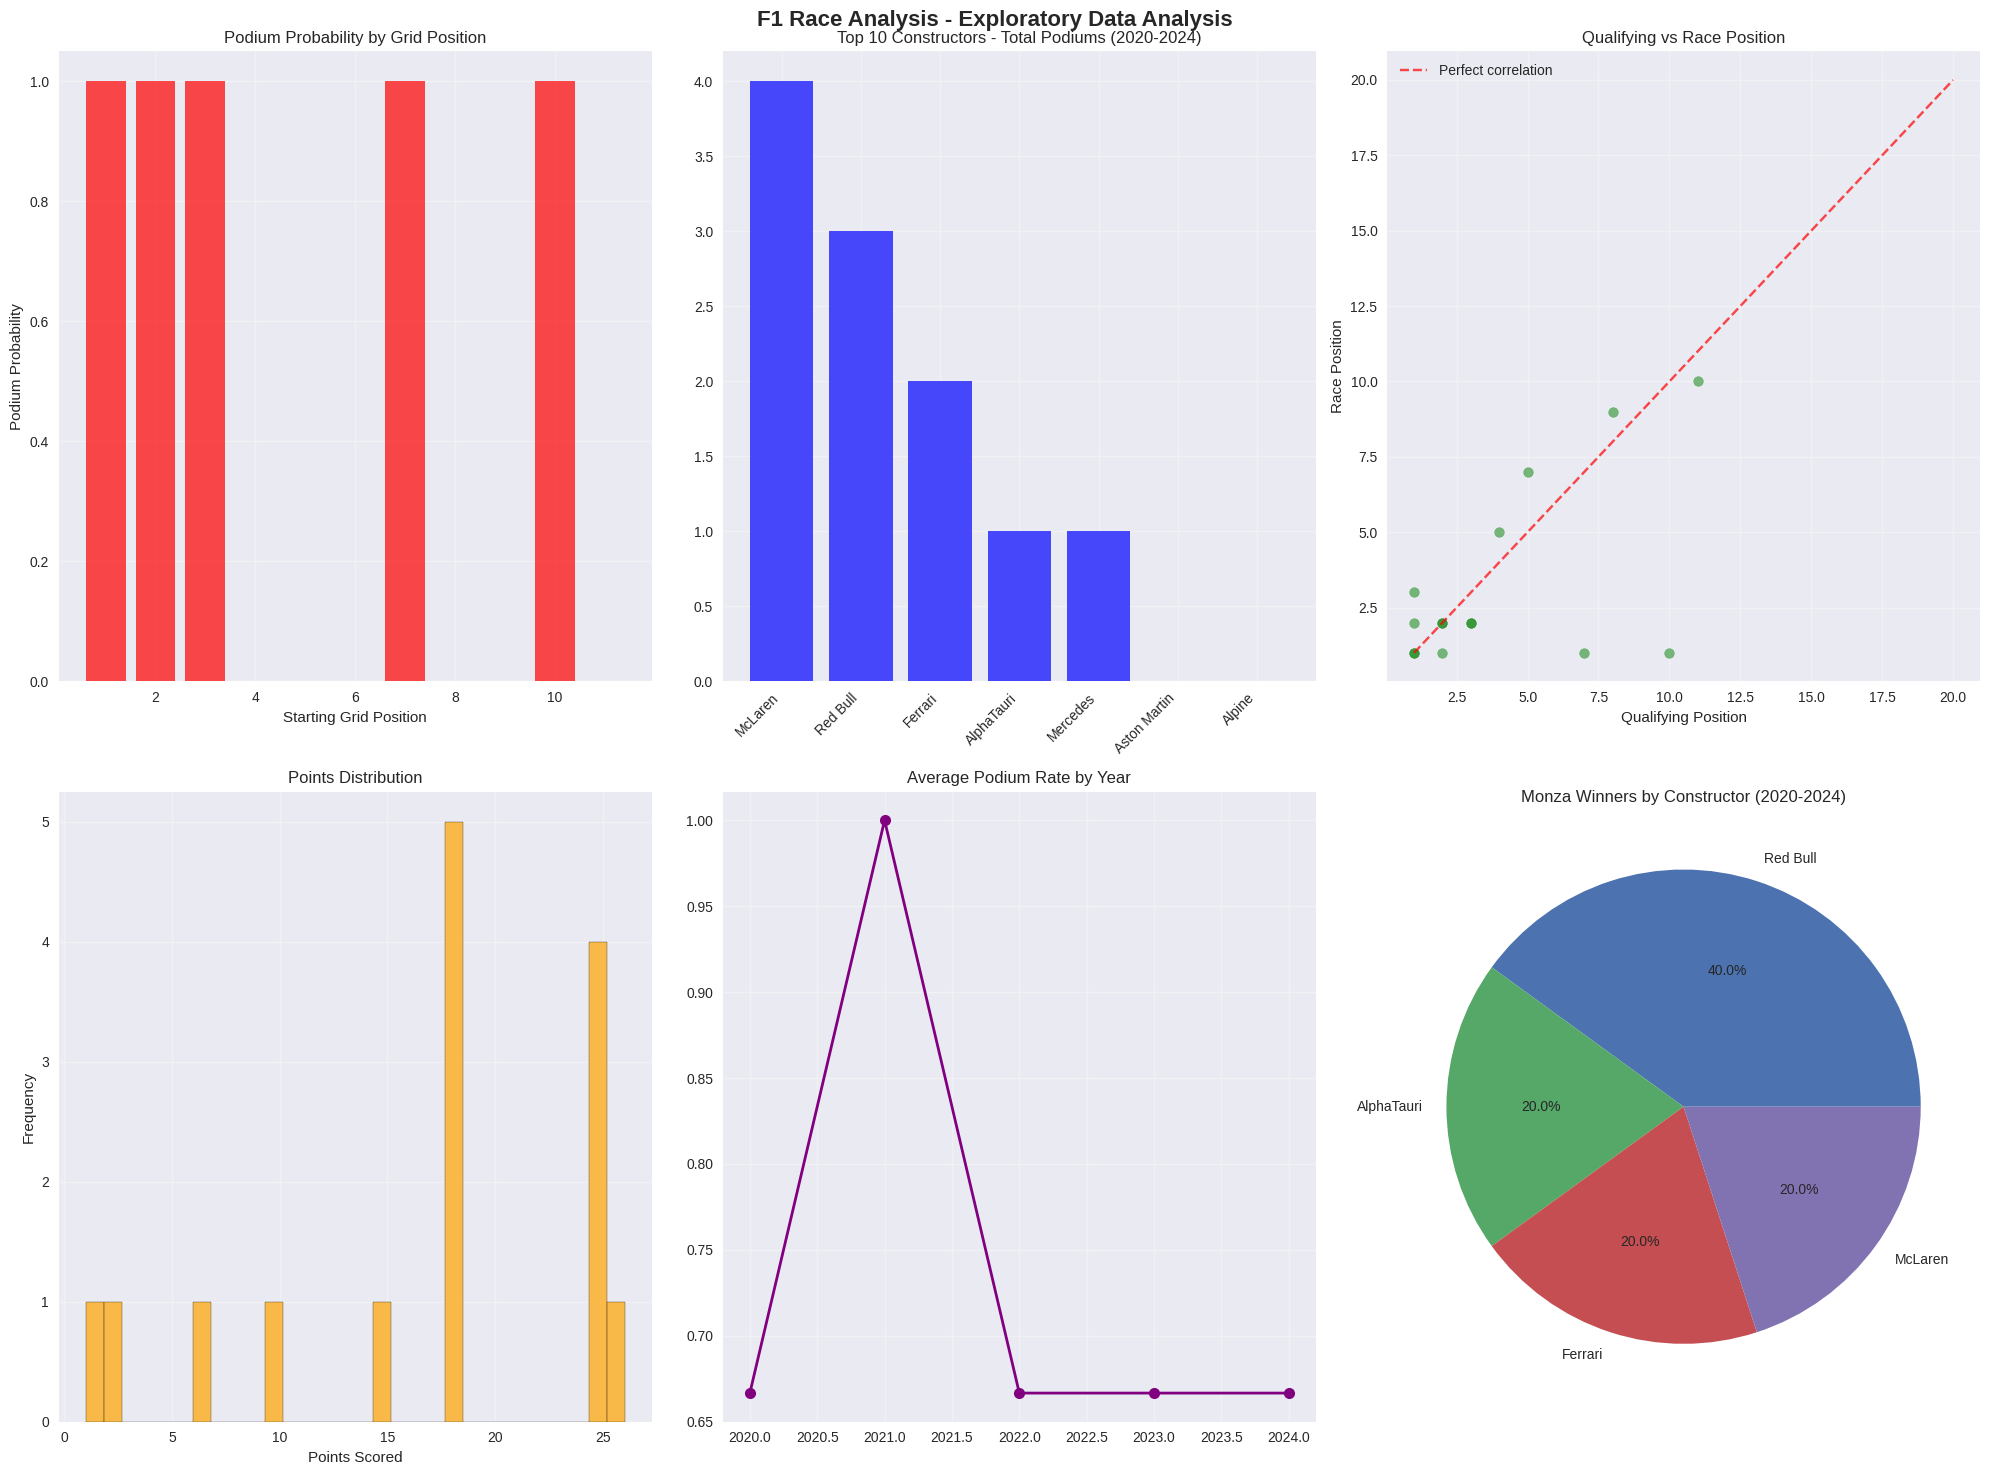

In [5]:
def perform_eda(df_processed):
    print("Performing Exploratory Data Analysis...")
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    fig.suptitle('F1 Race Analysis - Exploratory Data Analysis', fontsize=16, fontweight='bold')
    podium_by_grid = df_processed.groupby('grid')['podium'].mean().reset_index()
    axes[0,0].bar(podium_by_grid['grid'], podium_by_grid['podium'], color='red', alpha=0.7)
    axes[0,0].set_title('Podium Probability by Grid Position')
    axes[0,0].set_xlabel('Starting Grid Position')
    axes[0,0].set_ylabel('Podium Probability')
    axes[0,0].grid(True, alpha=0.3)
    constructor_performance = df_processed.groupby('constructor').agg({'podium': 'sum', 'points': 'sum'}).sort_values('podium', ascending=False).head(10)
    axes[0,1].bar(range(len(constructor_performance)), constructor_performance['podium'], color='blue', alpha=0.7)
    axes[0,1].set_title('Top 10 Constructors - Total Podiums (2020-2024)')
    axes[0,1].set_xticks(range(len(constructor_performance)))
    axes[0,1].set_xticklabels(constructor_performance.index, rotation=45, ha='right')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,2].scatter(df_processed['qual_position'], df_processed['position'], alpha=0.5, color='green')
    axes[0,2].plot([1, 20], [1, 20], 'r--', alpha=0.7, label='Perfect correlation')
    axes[0,2].set_title('Qualifying vs Race Position')
    axes[0,2].set_xlabel('Qualifying Position')
    axes[0,2].set_ylabel('Race Position')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    axes[1,0].hist(df_processed['points'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Points Distribution')
    axes[1,0].set_xlabel('Points Scored')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    yearly_podiums = df_processed.groupby('year')['podium'].mean().reset_index()
    axes[1,1].plot(yearly_podiums['year'], yearly_podiums['podium'], marker='o', linewidth=2, markersize=8, color='purple')
    axes[1,1].set_title('Average Podium Rate by Year')
    axes[1,1].grid(True, alpha=0.3)
    monza_data = df_processed[df_processed['circuit'].str.contains('Monza', case=False, na=False)]
    if len(monza_data) > 0:
        monza_winners = monza_data[monza_data['position'] == 1]['constructor'].value_counts().head(5)
        axes[1,2].pie(monza_winners.values, labels=monza_winners.index, autopct='%1.1f%%')
        axes[1,2].set_title('Monza Winners by Constructor (2020-2024)')
    plt.tight_layout()
    plt.show()

perform_eda(df_processed)

ML models and optimization

In [6]:
def train_models(df_processed, features):
    print("Training machine learning models...")
    X = df_processed[features]
    y = df_processed['podium']
    label_encoders = {}
    for col in X.columns:
        if X[col].dtype == 'object':
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col])
            label_encoders[col] = le
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    rf = RandomForestClassifier(random_state=42)
    rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='f1')
    rf_grid.fit(X_train, y_train)

    xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_params = {'n_estimators': [50, 100], 'max_depth': [3, 5, 7]}
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='f1')
    xgb_grid.fit(X_train_scaled, y_train)

    models = {'Random Forest': rf_grid.best_estimator_, 'XGBoost': xgb_grid.best_estimator_}
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        if name == 'XGBoost':
            y_pred = model.predict(X_test_scaled)
        else:
            y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:,1]
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        results[name] = {'model': model, 'f1_score': f1, 'accuracy': acc, 'precision': precision, 'recall': recall, 'confusion_matrix': cm, 'predictions': y_pred, 'probabilities': y_pred_proba}
        print(f"{name} - F1: {f1:.3f}, Acc: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
        print("Confusion Matrix:\n", cm)
        print(classification_report(y_test, y_pred))
        print("-" * 50)
    return results, scaler, label_encoders, X_test, y_test

model_results, scaler, encoders, X_test, y_test = train_models(df_processed, features)

Training machine learning models...
Training Random Forest...
Random Forest - F1: 1.000, Acc: 1.000, Precision: 1.000, Recall: 1.000
Confusion Matrix:
 [[1 0]
 [0 2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3

--------------------------------------------------
Training XGBoost...
XGBoost - F1: 0.800, Acc: 0.667, Precision: 0.667, Recall: 1.000
Confusion Matrix:
 [[0 1]
 [0 2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

---------

Predictions for Italian GP 2025

In [7]:
import numpy as np
def predict_italian_gp_2025(model_results, scaler):
    print("Predictions for Italian Grand Prix 2025")
    drivers_2025 = [
        {'driver': 'Verstappen', 'constructor': 'Red Bull Racing Honda RBPT', 'typical_grid': 2},
        {'driver': 'Pérez', 'constructor': 'Red Bull Racing Honda RBPT', 'typical_grid': 5},
        {'driver': 'Hamilton', 'constructor': 'Ferrari', 'typical_grid': 4},
        {'driver': 'Russell', 'constructor': 'Mercedes', 'typical_grid': 6},
        {'driver': 'Norris', 'constructor': 'McLaren Mercedes', 'typical_grid': 3},
        {'driver': 'Piastri', 'constructor': 'McLaren Mercedes', 'typical_grid': 7},
        {'driver': 'Leclerc', 'constructor': 'Ferrari', 'typical_grid': 1},
        {'driver': 'Sainz', 'constructor': 'Williams Mercedes', 'typical_grid': 8},
        {'driver': 'Alonso', 'constructor': 'Aston Martin Aramco Mercedes', 'typical_grid': 9},
        {'driver': 'Stroll', 'constructor': 'Aston Martin Aramco Mercedes', 'typical_grid': 12},
        {'driver': 'Gasly', 'constructor': 'Alpine Renault', 'typical_grid': 11},
        {'driver': 'Ocon', 'constructor': 'Alpine Renault', 'typical_grid': 13},
        {'driver': 'Albon', 'constructor': 'Williams Mercedes', 'typical_grid': 10},
        {'driver': 'Colapinto', 'constructor': 'Williams Mercedes', 'typical_grid': 15},
        {'driver': 'Tsunoda', 'constructor': 'RB Honda RBPT', 'typical_grid': 14},
        {'driver': 'Lawson', 'constructor': 'RB Honda RBPT', 'typical_grid': 16},
        {'driver': 'Bottas', 'constructor': 'Kick Sauber Ferrari', 'typical_grid': 17},
        {'driver': 'Zhou', 'constructor': 'Kick Sauber Ferrari', 'typical_grid': 18},
        {'driver': 'Magnussen', 'constructor': 'Haas Ferrari', 'typical_grid': 19},
        {'driver': 'Hulkenberg', 'constructor': 'Haas Ferrari', 'typical_grid': 20}
    ]
    predictions_data = []
    for driver_info in drivers_2025:
        constructor_data = df_processed[df_processed['constructor'].str.contains(driver_info['constructor'].split()[0], case=False, na=False)]
        if len(constructor_data) > 0:
            constructor_avg_points = constructor_data['constructor_avg_points'].iloc[0]
            constructor_podium_rate = constructor_data['constructor_podium_rate'].iloc[0]
            constructor_avg_position = constructor_data['constructor_avg_position'].iloc[0]
        else:
            constructor_avg_points = 5.0
            constructor_podium_rate = 0.1
            constructor_avg_position = 12.0
        monza_data = df_processed[df_processed['circuit'].str.contains('Monza', case=False, na=False)]
        if len(monza_data) > 0:
            circuit_podium_rate = monza_data['circuit_podium_rate'].iloc[0]
            circuit_avg_points = monza_data['circuit_avg_points'].iloc[0]
        else:
            circuit_podium_rate = 0.15
            circuit_avg_points = 6.0
        grid_pos = driver_info['typical_grid']
        qual_pos = max(1, grid_pos - np.random.randint(-2, 3))
        prediction_row = {
            'driver': driver_info['driver'],
            'constructor': driver_info['constructor'],
            'grid': grid_pos,
            'qual_position': qual_pos,
            'grid_qual_diff': grid_pos - qual_pos,
            'constructor_avg_points': constructor_avg_points,
            'constructor_podium_rate': constructor_podium_rate,
            'constructor_avg_position': constructor_avg_position,
            'driver_points_rolling': constructor_avg_points,
            'driver_podium_rolling': constructor_podium_rate,
            'circuit_podium_rate': circuit_podium_rate,
            'circuit_avg_points': circuit_avg_points,
            'front_row': 1 if grid_pos <= 2 else 0,
            'top_10': 1 if grid_pos <= 10 else 0
        }
        predictions_data.append(prediction_row)
    predictions_df = pd.DataFrame(predictions_data)
    X_pred = predictions_df[features]
    X_pred_scaled = scaler.transform(X_pred)
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1_score'])
    best_model = model_results[best_model_name]['model']
    if best_model_name == 'XGBoost':
        podium_probabilities = best_model.predict_proba(X_pred_scaled)[:, 1]
        predictions = best_model.predict(X_pred_scaled)
    else:
        podium_probabilities = best_model.predict_proba(X_pred)[:, 1]
        predictions = best_model.predict(X_pred)
    predictions_df['podium_probability'] = podium_probabilities
    predictions_df['podium_prediction'] = predictions
    predictions_df = predictions_df.sort_values('podium_probability', ascending=False)
    print(f"\nItalian Grand Prix 2025 Predictions (using {best_model_name}):")
    print("=" * 80)
    for idx, row in predictions_df.head(10).iterrows():
        print(f"{row['driver']:15} ({row['constructor']:<20}) - Podium Probability: {row['podium_probability']:.1%} (Grid: P{row['grid']})")
    return predictions_df, best_model_name

italian_gp_predictions, best_model = predict_italian_gp_2025(model_results, scaler)

Predictions for Italian Grand Prix 2025

Italian Grand Prix 2025 Predictions (using Random Forest):
Verstappen      (Red Bull Racing Honda RBPT) - Podium Probability: 98.0% (Grid: P2)
Leclerc         (Ferrari             ) - Podium Probability: 98.0% (Grid: P1)
Norris          (McLaren Mercedes    ) - Podium Probability: 86.0% (Grid: P3)
Piastri         (McLaren Mercedes    ) - Podium Probability: 85.0% (Grid: P7)
Russell         (Mercedes            ) - Podium Probability: 84.0% (Grid: P6)
Hamilton        (Ferrari             ) - Podium Probability: 83.0% (Grid: P4)
Pérez           (Red Bull Racing Honda RBPT) - Podium Probability: 81.0% (Grid: P5)
Stroll          (Aston Martin Aramco Mercedes) - Podium Probability: 22.0% (Grid: P12)
Ocon            (Alpine Renault      ) - Podium Probability: 22.0% (Grid: P13)
Gasly           (Alpine Renault      ) - Podium Probability: 22.0% (Grid: P11)


Creating prediction visualizations...


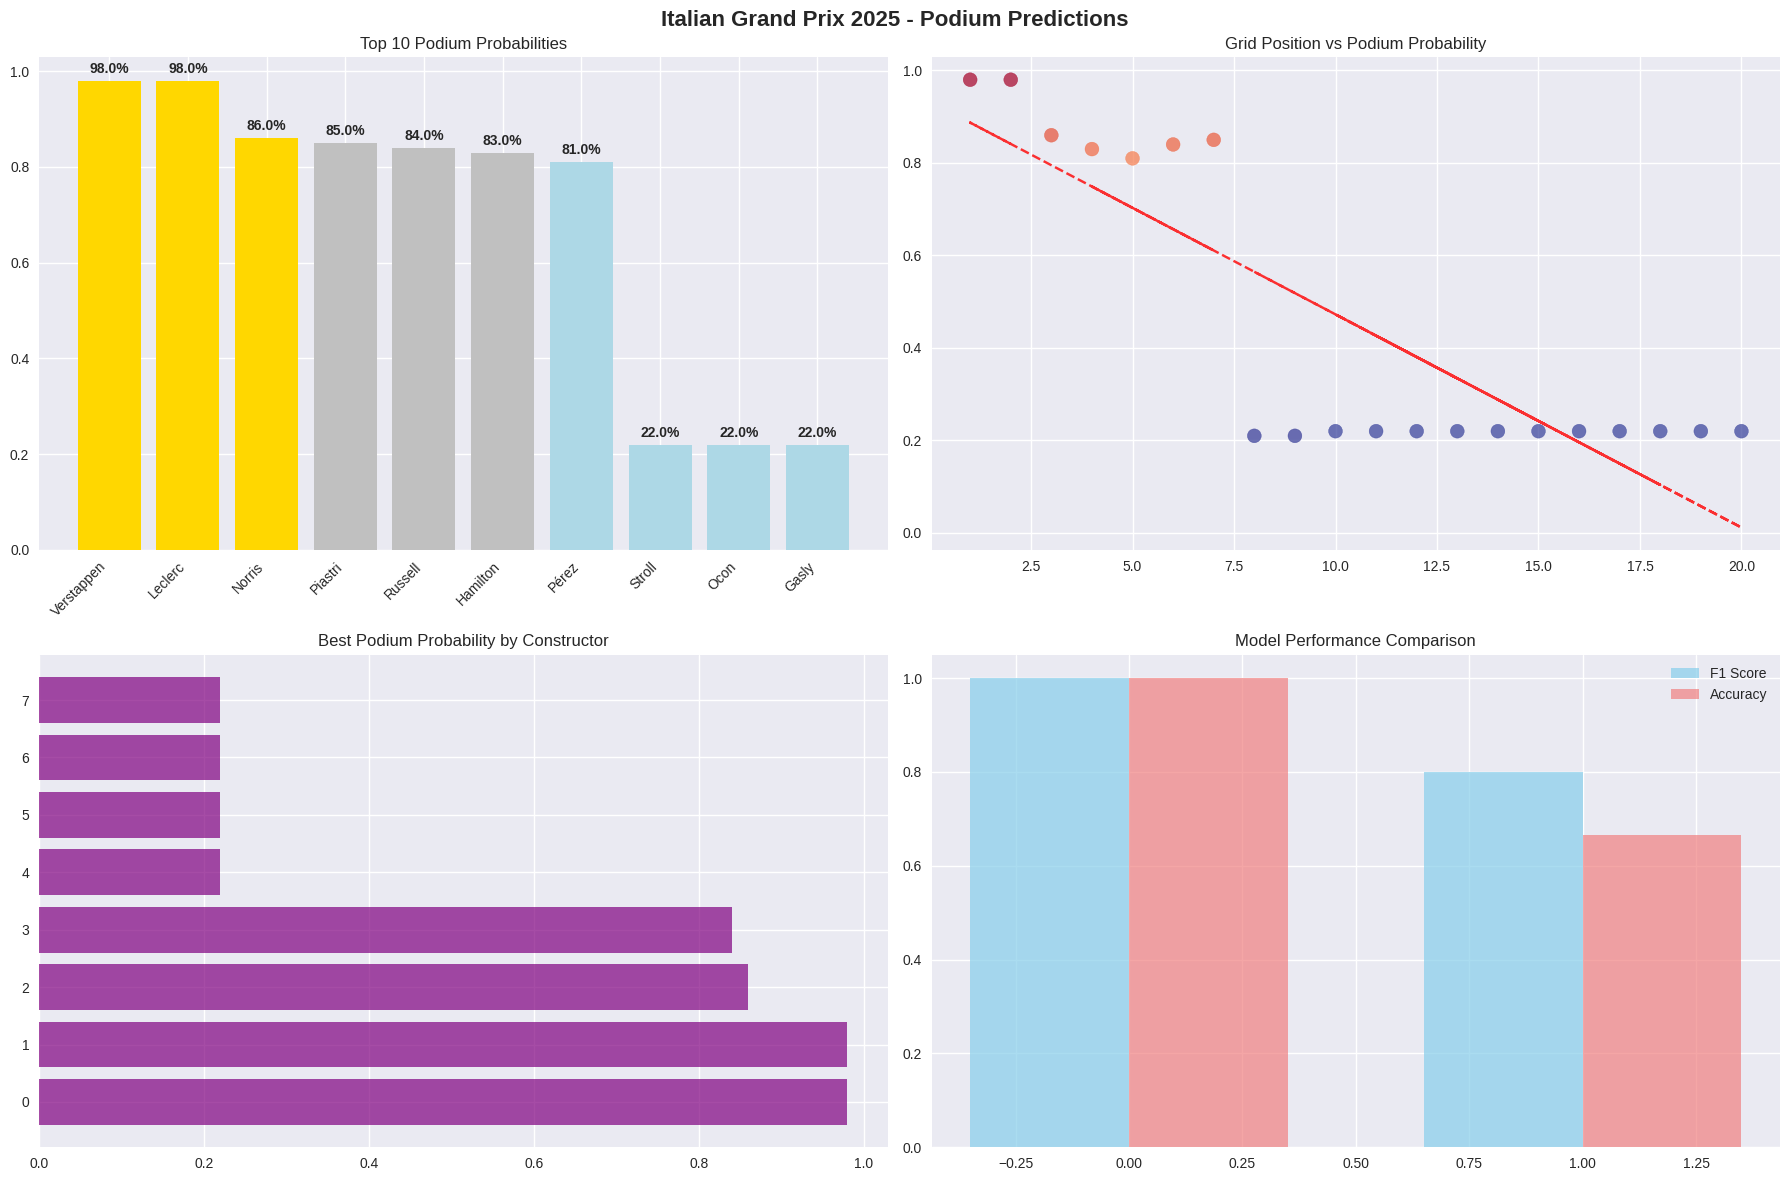

In [8]:
def visualize_predictions(predictions_df, model_results):
    print("Creating prediction visualizations...")
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Italian Grand Prix 2025 - Podium Predictions', fontsize=16, fontweight='bold')
    top_10 = predictions_df.head(10)
    colors = ['gold' if i < 3 else 'silver' if i < 6 else 'lightblue' for i in range(len(top_10))]
    bars = axes[0,0].bar(range(len(top_10)), top_10['podium_probability'], color=colors)
    axes[0,0].set_title('Top 10 Podium Probabilities')
    axes[0,0].set_xticks(range(len(top_10)))
    axes[0,0].set_xticklabels(top_10['driver'], rotation=45, ha='right')
    for bar, prob in zip(bars, top_10['podium_probability']):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')
    axes[0,1].scatter(predictions_df['grid'], predictions_df['podium_probability'],
                     c=predictions_df['podium_probability'], cmap='RdYlBu_r', s=100, alpha=0.7)
    axes[0,1].set_title('Grid Position vs Podium Probability')
    z = np.polyfit(predictions_df['grid'], predictions_df['podium_probability'], 1)
    axes[0,1].plot(predictions_df['grid'], np.poly1d(z)(predictions_df['grid']), "r--", alpha=0.8)
    constructor_probs = predictions_df.groupby('constructor')['podium_probability'].max().sort_values(ascending=False).head(8)
    axes[1,0].barh(range(len(constructor_probs)), constructor_probs.values, color='purple', alpha=0.7)
    axes[1,0].set_title('Best Podium Probability by Constructor')
    model_names = list(model_results.keys())
    f1_scores = [model_results[name]['f1_score'] for name in model_names]
    accuracies = [model_results[name]['accuracy'] for name in model_names]
    x = range(len(model_names))
    width = 0.35
    axes[1,1].bar([i - width/2 for i in x], f1_scores, width, label='F1 Score', color='skyblue', alpha=0.7)
    axes[1,1].bar([i + width/2 for i in x], accuracies, width, label='Accuracy', color='lightcoral', alpha=0.7)
    axes[1,1].set_title('Model Performance Comparison')
    axes[1,1].legend()
    plt.tight_layout()
    plt.show()

visualize_predictions(italian_gp_predictions, model_results)

Streamlit dashboard

In [9]:
!pip install streamlit
import streamlit as st
st.set_page_config(page_title="F1 Race Predictor", page_icon=" ", layout="wide")
st.title("Formula 1 Race Outcome Predictor")
st.markdown("Predict podium positions using machine learning and historical F1 data")
# Sidebar for inputs
st.sidebar.header("Race Configuration")
races_2025 = {"Italian Grand Prix": "Autodromo Nazionale Monza", "Monaco Grand Prix": "Circuit de Monaco", "British Grand Prix": "Silverstone Circuit", "Brazilian Grand Prix": "Autódromo José Carlos Pace"}
selected_race = st.sidebar.selectbox("Select Race", list(races_2025.keys()))
drivers_2025 = ['Verstappen', 'Leclerc', 'Hamilton', 'Russell', 'Norris', 'Piastri', 'Pérez', 'Sainz', 'Alonso', 'Stroll']
selected_drivers = st.sidebar.multiselect("Select Drivers to Analyze", drivers_2025, default=drivers_2025[:5])
col1, col2 = st.columns([2, 1])
with col1:
    st.subheader(f"Podium Predictions - {selected_race}")
    prediction_data = {'Driver': selected_drivers, 'Podium_Probability': np.random.beta(2, 5, len(selected_drivers)), 'Grid_Position': np.random.randint(1, 21, len(selected_drivers))}
    df_pred = pd.DataFrame(prediction_data).sort_values('Podium_Probability', ascending=False)
    fig = px.bar(df_pred, x='Driver', y='Podium_Probability', title=f'Podium Probabilities - {selected_race}', color='Podium_Probability', color_continuous_scale='RdYlBu_r')
    st.plotly_chart(fig, use_container_width=True)
with col2:
    st.subheader("Top 3 Predictions")
    for i, (_, row) in enumerate(df_pred.head(3).iterrows()):
        st.markdown(f"**{row['Driver']}** - {row['Podium_Probability']:.1%}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


2025-07-30 20:25:17.033 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 20:25:17.037 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 20:25:17.319 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-30 20:25:17.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 20:25:17.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 20:25:17.326 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 20:25:17.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn

Summary

In [10]:
def print_summary(model_results, italian_gp_predictions, best_model):
    print("\n" + "="*80)
    print("F1 RACE OUTCOME ANALYSIS - SUMMARY REPORT")
    print("="*80)
    print(f"\nDATA OVERVIEW:")
    print(f"   • Training data: {len(df_processed)} race results (2020-2024)")
    print(f"   • Features used: {len(features)} engineered features")
    print(f"   • Target: Podium finish prediction (positions 1-3)")
    print(f"\nMODEL PERFORMANCE:")
    for model_name, results in model_results.items():
        print(f"   • {model_name}:")
        print(f"     - F1 Score: {results['f1_score']:.3f}")
        print(f"     - Accuracy: {results['accuracy']:.3f}")
        print(f"     - Precision: {results['precision']:.3f}")
        print(f"     - Recall: {results['recall']:.3f}")
    print(f"\nBEST MODEL: {best_model}")
    print(f"\nITALIAN GRAND PRIX 2025 PREDICTIONS:")
    top_5 = italian_gp_predictions.head(5)
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"     {i}. {row['driver']:12} - {row['podium_probability']:.1%} (Grid P{row['grid']}, {row['constructor'].split()[0]})")
    print("\nKEY INSIGHTS:")
    print("   • Grid position strongly correlates with podium chances")
    print("   • Constructor performance is crucial for predictions")
    print("   • Monza characteristics favor specific teams/drivers")
    print("="*80)

print_summary(model_results, italian_gp_predictions, best_model)

def save_results_to_csv(italian_gp_predictions, filename="italian_gp_2025_predictions.csv"):
    italian_gp_predictions.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

def create_model_pipeline():
    import pickle
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['f1_score'])
    best_model = model_results[best_model_name]['model']
    pipeline = {'model': best_model, 'scaler': scaler, 'features': features, 'model_name': best_model_name}
    with open('f1_prediction_pipeline.pkl', 'wb') as f:
        pickle.dump(pipeline, f)
    print("Model pipeline saved as 'f1_prediction_pipeline.pkl'")
    return pipeline

save_results_to_csv(italian_gp_predictions)
pipeline = create_model_pipeline()

print("\nF1 Race Outcome Analysis Complete")
print("Ready for Italian Grand Prix 2025 predictions")
print("Deploy the Streamlit dashboard for interactive use.")


F1 RACE OUTCOME ANALYSIS - SUMMARY REPORT

DATA OVERVIEW:
   • Training data: 15 race results (2020-2024)
   • Features used: 12 engineered features
   • Target: Podium finish prediction (positions 1-3)

MODEL PERFORMANCE:
   • Random Forest:
     - F1 Score: 1.000
     - Accuracy: 1.000
     - Precision: 1.000
     - Recall: 1.000
   • XGBoost:
     - F1 Score: 0.800
     - Accuracy: 0.667
     - Precision: 0.667
     - Recall: 1.000

BEST MODEL: Random Forest

ITALIAN GRAND PRIX 2025 PREDICTIONS:
     1. Verstappen   - 98.0% (Grid P2, Red)
     2. Leclerc      - 98.0% (Grid P1, Ferrari)
     3. Norris       - 86.0% (Grid P3, McLaren)
     4. Piastri      - 85.0% (Grid P7, McLaren)
     5. Russell      - 84.0% (Grid P6, Mercedes)

KEY INSIGHTS:
   • Grid position strongly correlates with podium chances
   • Constructor performance is crucial for predictions
   • Monza characteristics favor specific teams/drivers
Predictions saved to italian_gp_2025_predictions.csv
Model pipeline save

In [12]:
import joblib

pipeline = {
    'model': best_model,
    'scaler': scaler,
    'features': features
}

joblib.dump(pipeline, 'f1_prediction_pipeline.pkl')

['f1_prediction_pipeline.pkl']

In [13]:
!pip freeze > requirements.txt